In [1]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# #from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np
# import os
# from pandas.tseries.offsets import *
# import calendar
# import os
# #from shapely.geometry import Point

In [4]:
# Initialize Earth Engine
geemap.ee.Initialize()

In [5]:
# Path to the GeoPackage
gpk_path = r"C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Cartography\Administrativo\Colombia_Admin.gpkg"

# Layer name within the GeoPackage
layer_name = 'Colombia_Admin_Level0'

# Read the layer from the GeoPackage
colombia_admin0 = gpd.read_file(gpk_path, layer=layer_name)

# Reproject to WGS84
colombia_admin0 = colombia_admin0.to_crs(epsg=4326)
# Convert the GeoDataFrame to an Earth Engine FeatureCollection
colombia_admin0_ee = geemap.geopandas_to_ee(colombia_admin0)

In [89]:
# Countries Boundaries and Basin Boundaries combined
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
colombia = world.loc[world['name'] == 'Colombia'] # Aquí se tiene solamente las fronteras de Colombia.
colombia_admin0=colombia
# Convert the GeoDataFrame to an Earth Engine FeatureCollection
colombia_admin0_ee = geemap.geopandas_to_ee(colombia_admin0)
region = colombia_admin0_ee.geometry().bounds().getInfo()

In [3]:
# Initialize earth engine (If it's the first time, you need to authenticate)
ee.Authenticate()


Successfully saved authorization token.


## Multiannual Per Month

In [50]:
# Define the CHIRPS ImageCollection for pentads from 1990 to 2023
chirps_collection = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")\
    .filterDate('1990-01-01', '2023-12-31').select('precipitation')

# Function to calculate the sum of pentads for a given month across all years
def sum_pentads_by_month(month):
    # Filter the collection by the specified month
    monthly_collection = chirps_collection.filter(ee.Filter.calendarRange(month, month, 'month'))
    
    # Sum the pentads for the given month across all years
    monthly_sum = monthly_collection.sum().set('month', month)
    # Calculate the mean and median as individual images
    monthly_mean = monthly_sum.mean().set('month', month, 'stat', 'mean')
    monthly_median = monthly_sum.median().set('month', month, 'stat', 'median')
    return monthly_sum,monthly_mean,monthly_median


# List of months to process (1 to 12)
months = ee.List.sequence(1, 12)

# Map the sum_pentads_by_month function over the list of months to calculate monthly sums
monthly_sums = ee.ImageCollection(months.map(sum_pentads_by_month))
print(f"Number of images in the Monthly collection: {monthly_sums.size().getInfo()}")



Number of images in the Monthly collection: 12


In [86]:
# Define the CHIRPS ImageCollection for pentads from 1990 to 2023
chirps_collection = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")\
    .filterDate('1990-01-01', '2023-12-31').select('precipitation')

# Function to sum the pentads for each month of each year
def sum_pentads_by_month_and_year(year, month):
    # Filter the collection by the specified year and month
    monthly_collection = chirps_collection.filter(ee.Filter.calendarRange(year, year, 'year'))\
                                          .filter(ee.Filter.calendarRange(month, month, 'month'))
    
    # Sum the pentads for the given month of the specified year
    monthly_sum = monthly_collection.sum().set('year', year, 'month', month)
    return monthly_sum

# List of years to process (1990 to 2023)
years = ee.List.sequence(1990, 2023)

# List of months to process (1 to 12)
months = ee.List.sequence(1, 12)

# Create a list of all year-month combinations
year_month_combinations = years.map(lambda y: months.map(lambda m: ee.List([y, m]))).flatten()

# Map the sum_pentads_by_month_and_year function over the list of year-month combinations
intermediary_collection = ee.ImageCollection(year_month_combinations.map(lambda ym: sum_pentads_by_month_and_year(ee.Number(ee.List(ym).get(0)), ee.Number(ee.List(ym).get(1)))))

# Print the number of images in the intermediary collection
print(f"Number of images in the Intermediary Collection: {intermediary_collection.size().getInfo()}")

# Define the region of interest (example: Colombia)

EEException: List.get, argument 'list': Invalid type.
Expected type: List<Object>.
Actual type: Float.
Actual value: 1990.0

In [100]:
# Define the CHIRPS ImageCollection for pentads from 1990 to 2023
chirps_collection = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")\
    .filterDate('1990-01-01', '2023-12-31').select('precipitation')

# Function to sum the pentads for each month of each year
def sum_pentads_by_month_and_year(year, month):
    # Filter the collection by the specified year and month
    monthly_collection = chirps_collection.filter(ee.Filter.calendarRange(year, year, 'year'))\
                                          .filter(ee.Filter.calendarRange(month, month, 'month'))
    
    # Sum the pentads for the given month of the specified year
    monthly_sum = monthly_collection.sum().set('year', year, 'month', month)
    return monthly_sum

# List of years to process (1990 to 2023)
years = ee.List.sequence(1990, 2023)

# List of months to process (1 to 12)
months = ee.List.sequence(1, 12)

# Create a list of all year-month combinations
year_month_combinations = years.map(lambda y: months.map(lambda m: ee.List([y, m]))).flatten()

# Map the sum_pentads_by_month_and_year function over the list of year-month combinations
intermediary_collection = ee.ImageCollection(year_month_combinations.map(lambda ym: sum_pentads_by_month_and_year(ee.Number(ee.List(ym).get(0)), ee.Number(ee.List(ym).get(1)))))

# Define the region of interest (example: Colombia)
region = ee.Geometry.Polygon(
    [[[-79.0, 12.5], [-79.0, -4.5], [-66.5, -4.5], [-66.5, 12.5], [-79.0, 12.5]]]
)


# Function to export each monthly summed image
def export_monthly_images(image, year, month):
    description = f'Pentad_Sum_{year}_{month}'
    
    task = ee.batch.Export.image.toDrive(**{
        'image': image,
        'description': description,
        'folder': 'CHIRPS_Pentad_Sum',
        'scale': 5000,
        'region': region,
        'maxPixels': 1e13
    })
    task.start()

# Loop through each year and month, sum the pentads, and export the image
for year in range(1990, 2024):
    for month in range(1, 13):
        image = sum_pentads_by_month_and_year(year, month)
        export_monthly_images(image, year, month)

print("Export of monthly summed images to Google Drive started.")

Export of monthly summed images to Google Drive started.


# Org.in subfolder


In [101]:
import os
import shutil

# Define the source directory containing the raster files
source_dir = r'C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum'

# Define the target directories for each month
months = {
    '1': 'january',
    '2': 'february',
    '3': 'march',
    '4': 'april',
    '5': 'may',
    '6': 'june',
    '7': 'july',
    '8': 'august',
    '9': 'september',
    '10': 'october',
    '11': 'november',
    '12': 'december'
}

# Create target directories if they don't exist
for month in months.values():
    os.makedirs(os.path.join(source_dir, month), exist_ok=True)

# Move files to the corresponding month folder
for filename in os.listdir(source_dir):
    if filename.startswith('Pentad_Sum_'):
        parts = filename.split('_')
        if len(parts) == 4:
            month = parts[3].split('.')[0]  # Extract the month part
            if month in months:
                target_dir = os.path.join(source_dir, months[month])
                shutil.move(os.path.join(source_dir, filename), os.path.join(target_dir, filename))

print("Files have been organized into month folders.")

Files have been organized into month folders.


In [107]:
import os
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Define the source directory containing the month subfolders
source_dir = r'C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum'

# Define the target directories for each month
months = {
    '1': 'january',
    '2': 'february',
    '3': 'march',
    '4': 'april',
    '5': 'may',
    '6': 'june',
    '7': 'july',
    '8': 'august',
    '9': 'september',
    '10': 'october',
    '11': 'november',
    '12': 'december'
}

# Function to stack rasters and calculate the mean
def calculate_mean_stack(raster_paths):
    stack = []
    for raster_path in raster_paths:
        with rasterio.open(raster_path) as src:
            data = src.read(1)  # Read the first band
            data = np.where(data == src.nodata, np.nan, data)  # Replace nodata values with NaN
            stack.append(data)
    stack = np.array(stack)
    mean_stack = np.nanmean(stack, axis=0)  # Calculate mean ignoring NaN values
    return mean_stack

# Function to create a new raster from an array
def create_raster_from_array(src_path, array, output_path):
    with rasterio.open(src_path) as src:
        meta = src.meta.copy()
        meta.update(dtype=rasterio.float32, count=1, compress='lzw')
        
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(array, 1)

# Loop through each month folder, calculate the mean stack, and export the mean raster
for month_num, month_name in months.items():
    month_dir = os.path.join(source_dir, month_name)
    if os.path.exists(month_dir):
        raster_paths = [os.path.join(month_dir, f) for f in os.listdir(month_dir) if f.endswith('.tif')]
        if raster_paths:
            mean_stack = calculate_mean_stack(raster_paths)
            
            # Define output path for the mean raster
            mean_output_path = os.path.join(month_dir, f'Pentad_Sum_{month_name}_mean.tif')
            
            # Create and save the mean raster
            create_raster_from_array(raster_paths[0], mean_stack, mean_output_path)
            
            print(f"Mean raster created for {month_name} and saved to {mean_output_path}")

print("Calculation and export of mean rasters completed.")

Mean raster created for january and saved to C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum\january\Pentad_Sum_january_mean.tif
Mean raster created for february and saved to C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum\february\Pentad_Sum_february_mean.tif
Mean raster created for march and saved to C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum\march\Pentad_Sum_march_mean.tif
Mean raster created for april and saved to C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum\april\Pentad_Sum_april_mean.tif
Mean raster created for may and saved to C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum\may\Pentad_Sum_may_mean.tif
Mean raster created for june and saved to C:\Users\alexa\Desktop\CHIRPS_Pentad_Sum-20241005T011936Z-001\CHIRPS_Pentad_Sum\june\Pentad_Sum_june_mean.tif
Mean raster created for july and saved to C:\Users\alexa\Desktop

In [32]:
# Define the TerraClimate dataset
dataset = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')

# Filter for temperature (mean) from 1990 to 2023
temperature_collection = dataset.filterDate('1990-01-01', '2023-12-31').select('tmmx')

# Define the region of interest (Colombia)
colombia = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')\
    .filter(ee.Filter.eq('country_na', 'Colombia'))

# Create a single image by taking the mean of the temperature collection
temperature_mean = temperature_collection.mean()

# Define export parameters
export_params = {
    'image': temperature_mean,
    'description': 'Colombia_Temperature_MAX_1990_2023',
    'folder': 'EarthEngineExports',
    'scale': 5000,
    'region': colombia.geometry().bounds(),
    'maxPixels': 1e13
}

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

print("Export task started. Check the Earth Engine Code Editor 'Tasks' tab for progress.")



Export task started. Check the Earth Engine Code Editor 'Tasks' tab for progress.


In [33]:
# Define the TerraClimate dataset
dataset = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')

# Filter for precipitation from 1990 to 2023
precipitation_collection = dataset.filterDate('1990-01-01', '2023-12-31').select('pr')

# Define the region of interest (Colombia)
colombia = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')\
    .filter(ee.Filter.eq('country_na', 'Colombia'))

# Create a single image by taking the mean of the precipitation collection
precipitation_mean = precipitation_collection.mean()

# Define export parameters
export_params = {
    'image': precipitation_mean,
    'description': 'Colombia_Precipitation_Mean_1990_2023',
    'folder': 'EarthEngineExports',
    'scale': 5000,
    'region': colombia.geometry().bounds(),
    'maxPixels': 1e13
}

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

print("Export task started. Check the Earth Engine Code Editor 'Tasks' tab for progress.")

Export task started. Check the Earth Engine Code Editor 'Tasks' tab for progress.


In [ ]:
# Clip the temperature data to the region of Colombia
temperature_colombia = temperature_collection.mean().clip(colombia)

# Set export parameters
export_params = {
    'scale': 5000,  # resolution in meters
    'region': colombia.geometry()
}

# Export the image to Google Drive
ee_export_image(temperature_colombia,filename='Colombia_Temperature_1990to2023',**export_params)


In [26]:
# Path to the GeoPackage
gpk_path = r"C:\Users\alexa\Documents\PERSONAL PROJECTS\Colombia Cartography\Administrativo\Colombia_Admin.gpkg"

# Layer name within the GeoPackage
layer_name = 'Colombia_Admin_Level0'

# Read the layer from the GeoPackage
colombia_admin0 = gpd.read_file(gpk_path, layer=layer_name)

# Reproject to WGS84
colombia_admin0 = colombia_admin0.to_crs(epsg=4326)


In [6]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
import pandas as pd

In [19]:
# Load Colombia boundary shapefile
colombia_boundary =colombia_admin0
temperature_path=r"C:\Users\alexa\Desktop\Temperature_Colombia.tif"
precipitation_path=r"C:\Users\alexa\Desktop\Precipitation_Colombia.tif"
# Load temperature and precipitation rasters
with rasterio.open(temperature_path) as temp_src, rasterio.open(precipitation_path) as ppt_src:
    # Reproject both rasters to match the Colombia boundary CRS
    temp_data = temp_src.read(1)
    ppt_data = ppt_src.read(1)
    temp_transform = temp_src.transform
    ppt_transform = ppt_src.transform

    # Ensure both rasters have the same CRS as the Colombia boundary
    if temp_src.crs != colombia_boundary.crs:
        colombia_boundary = colombia_boundary.to_crs(temp_src.crs)



In [8]:
import numpy as np
import pandas as pd
import rasterio

def raster_to_dataframe(raster_data, transform):
    """Convert raster data to a DataFrame with X, Y coordinates."""
    coords = []
    values = []
    for row in range(raster_data.shape[0]):
        for col in range(raster_data.shape[1]):
            x, y = rasterio.transform.xy(transform, row, col)
            value = raster_data[row, col]
            if np.isfinite(value):
                coords.append((x, y))
                values.append(value)
    return pd.DataFrame(coords, columns=['x', 'y']), pd.Series(values)

# Get coordinates and values for temperature and precipitation
temp_coords_df, temp_values = raster_to_dataframe(temp_data, temp_transform)
ppt_coords_df, ppt_values = raster_to_dataframe(ppt_data, ppt_transform)

# Merge into a single DataFrame
raster_df = pd.concat([temp_coords_df, temp_values.rename('temp'), ppt_values.rename('ppt')], axis=1)


# Assuming raster_df is your DataFrame
raster_df.loc[raster_df['temp'] < -3400, 'temp'] = np.nan

# Set 'ppt' to NaN where 'temp' is NaN
raster_df.loc[raster_df['temp'].isna(), 'ppt'] = np.nan

raster_df.sample(5)

,x,y,temp,ppt
56782,-75.301279,2.986898,27.274632,155.818627
40685,-70.674955,5.681844,27.447060,167.002451
17473,-70.315629,9.544600,NaN,NaN
31634,-77.008078,7.164064,28.131128,282.764706
45855,-68.878324,4.828445,27.935171,239.950980


In [22]:
raster_df.shape

(45933, 9)

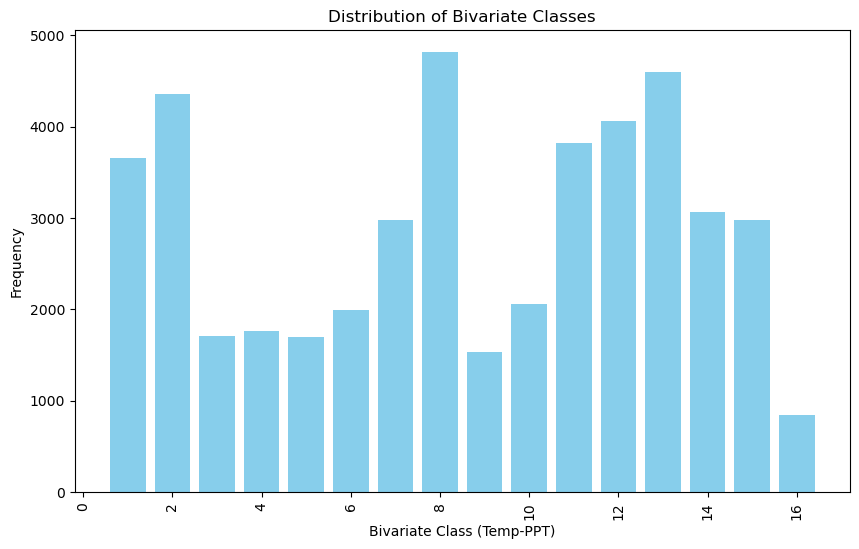

<bound method NDFrame.to_csv of    bi_class  bi_class_int                     bi_class_desc
0       0-0             1                  Low temp-Low ppt
1       0-1             2           Low temp-Medium Low ppt
2       0-2             3          Low temp-Medium High ppt
3       0-3             4                 Low temp-High ppt
4       1-0             5           Medium Low temp-Low ppt
5       1-1             6    Medium Low temp-Medium Low ppt
6       1-2             7   Medium Low temp-Medium High ppt
7       1-3             8          Medium Low temp-High ppt
8       2-0             9          Medium High temp-Low ppt
9       2-1            10   Medium High temp-Medium Low ppt
10      2-2            11  Medium High temp-Medium High ppt
11      2-3            12         Medium High temp-High ppt
12      3-0            13                 High temp-Low ppt
13      3-1            14          High temp-Medium Low ppt
14      3-2            15         High temp-Medium High ppt
15      

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming raster_df is already defined and contains 'temp' and 'ppt' columns

# Drop rows with NaN values
raster_df.dropna(inplace=True)

# Create quantile-based classification for temperature and precipitation
raster_df['temp_class'] = pd.qcut(raster_df['temp'], q=4, labels=False)
raster_df['ppt_class'] = pd.qcut(raster_df['ppt'], q=4, labels=False)

# Create a bivariate class
raster_df['bi_class'] = raster_df['temp_class'].astype(str) + "-" + raster_df['ppt_class'].astype(str)

# Create a mapping from bivariate class to integer value and description
bi_class_mapping = {
    '0-0': (1, 'Low temp-Low ppt'), '0-1': (2, 'Low temp-Medium Low ppt'), '0-2': (3, 'Low temp-Medium High ppt'), '0-3': (4, 'Low temp-High ppt'),
    '1-0': (5, 'Medium Low temp-Low ppt'), '1-1': (6, 'Medium Low temp-Medium Low ppt'), '1-2': (7, 'Medium Low temp-Medium High ppt'), '1-3': (8, 'Medium Low temp-High ppt'),
    '2-0': (9, 'Medium High temp-Low ppt'), '2-1': (10, 'Medium High temp-Medium Low ppt'), '2-2': (11, 'Medium High temp-Medium High ppt'), '2-3': (12, 'Medium High temp-High ppt'),
    '3-0': (13, 'High temp-Low ppt'), '3-1': (14, 'High temp-Medium Low ppt'), '3-2': (15, 'High temp-Medium High ppt'), '3-3': (16, 'High temp-High ppt')
}

# Apply the mapping to create new columns with integer values and descriptions
raster_df['bi_class_int'] = raster_df['bi_class'].map(lambda x: bi_class_mapping[x][0])
raster_df['bi_class_desc'] = raster_df['bi_class'].map(lambda x: bi_class_mapping[x][1])

# Display distribution of the bivariate classes
class_distribution = raster_df['bi_class_int'].value_counts().reset_index()
class_distribution.columns = ['bi_class_int', 'count']

# Plot the distribution of bivariate classes
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['bi_class_int'], class_distribution['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Distribution of Bivariate Classes')
plt.xlabel('Bivariate Class (Temp-PPT)')
plt.ylabel('Frequency')
plt.show()

# Display the mapping for reference
bi_class_mapping_df = pd.DataFrame([(k, v[0], v[1]) for k, v in bi_class_mapping.items()], columns=['bi_class', 'bi_class_int', 'bi_class_desc'])


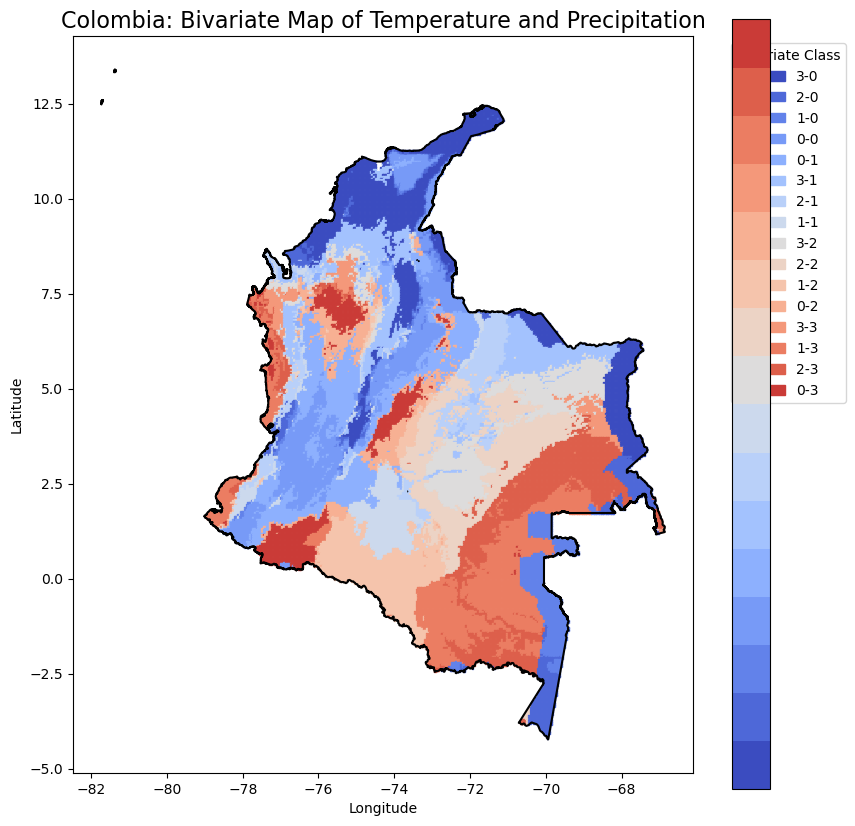

In [105]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling

# Assuming raster_df is already defined and contains 'x', 'y', and 'bi_class' columns
# Assuming colombia_admin0 is already defined and contains the Colombia boundary shapefile

# Set up a bivariate color palette (adjust to your needs)
palette = sns.color_palette("coolwarm", as_cmap=True)

# Create a color mapping for the bivariate classes
unique_classes = raster_df['bi_class'].unique()
color_mapping = {cls: palette(i / len(unique_classes)) for i, cls in enumerate(unique_classes)}

# Map the bivariate classes to colors
raster_df['color'] = raster_df['bi_class'].map(color_mapping)

# Load Colombia boundary shapefile
colombia_boundary = colombia_admin0

# Plot the bivariate raster data
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data
sc = ax.scatter(raster_df['x'], raster_df['y'], c=raster_df['color'], s=1, marker='s')

# Plot the Colombia boundary shapefile
colombia_boundary.boundary.plot(ax=ax, edgecolor='black')

# Add title and labels
ax.set_title("Colombia: Bivariate Map of Temperature and Precipitation", fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add colorbar for the bivariate classes
# Create a custom colorbar
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Create a colormap and norm
cmap = ListedColormap([color_mapping[cls] for cls in unique_classes])
norm = plt.Normalize(vmin=0, vmax=len(unique_classes) - 1)

# Create a colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_ticks([])  # Remove ticks

# Create a legend with the bivariate classes
handles = [mpatches.Patch(color=color_mapping[cls], label=cls) for cls in unique_classes]
ax.legend(handles=handles, title='Bivariate Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [108]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin

# Assuming raster_df is already defined and contains 'x', 'y', and 'bi_class' columns

# Define the raster size and resolution
x_min, x_max = raster_df['x'].min(), raster_df['x'].max()
y_min, y_max = raster_df['y'].min(), raster_df['y'].max()
resolution = 0.01  # Adjust the resolution as needed

# Calculate the number of rows and columns
n_cols = int((x_max - x_min) / resolution) + 1
n_rows = int((y_max - y_min) / resolution) + 1

# Create an empty array for the raster data
raster_data = np.full((n_rows, n_cols), -1, dtype=np.int32)

# Map the bivariate classes to integer values
unique_classes = raster_df['bi_class'].unique()
class_mapping = {cls: i + 1 for i, cls in enumerate(unique_classes)}  # Start mapping from 1
raster_df['class_int'] = raster_df['bi_class'].map(class_mapping)

# Populate the raster data array
for _, row in raster_df.iterrows():
    col = int((row['x'] - x_min) / resolution)
    row_idx = int((y_max - row['y']) / resolution)
    raster_data[row_idx, col] = row['class_int']

# Define the transform
transform = from_origin(x_min, y_max, resolution, resolution)

# Write the raster data to a file
with rasterio.open(
    'bivariate_map.tif',
    'w',
    driver='GTiff',
    height=n_rows,
    width=n_cols,
    count=1,
    dtype=raster_data.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(raster_data, 1)

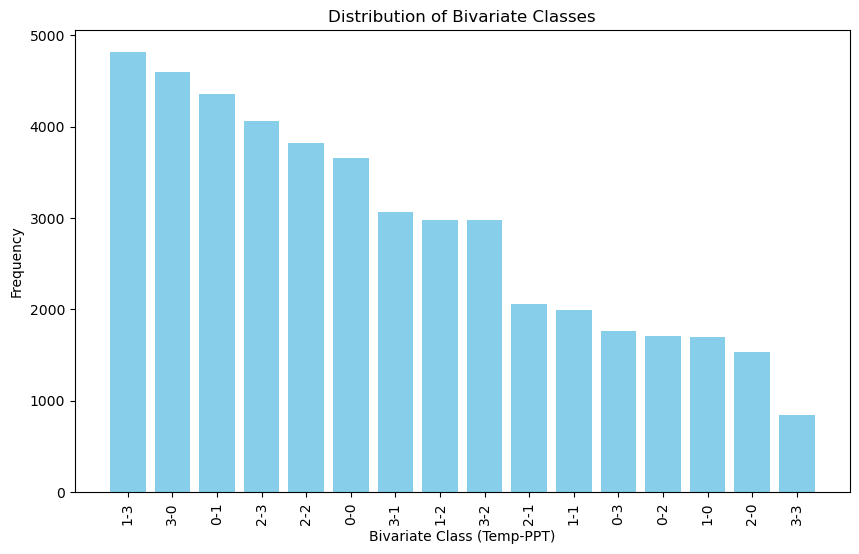

In [110]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Assuming raster_df is already defined and contains 'x', 'y', 'temp', 'ppt', and 'bi_class' columns

# Drop rows with NaN values
raster_df.dropna(inplace=True)

# Create quantile-based classification for temperature and precipitation
raster_df['temp_class'] = pd.qcut(raster_df['temp'], q=4, labels=False)
raster_df['ppt_class'] = pd.qcut(raster_df['ppt'], q=4, labels=False)

# Create a bivariate class
raster_df['bi_class'] = raster_df['temp_class'].astype(str) + "-" + raster_df['ppt_class'].astype(str)

# Display distribution of the bivariate classes
class_distribution = raster_df['bi_class'].value_counts().reset_index()
class_distribution.columns = ['bi_class', 'count']

# Plot the distribution of bivariate classes
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['bi_class'], class_distribution['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Distribution of Bivariate Classes')
plt.xlabel('Bivariate Class (Temp-PPT)')
plt.ylabel('Frequency')
plt.show()

# Export raster_df as a CSV file with coordinates
raster_df.to_csv('raster_data_with_coordinates.csv', index=False)

# Define the raster size and resolution
x_min, x_max = raster_df['x'].min(), raster_df['x'].max()
y_min, y_max = raster_df['y'].min(), raster_df['y'].max()
resolution = 0.01  # Adjust the resolution as needed

# Calculate the number of rows and columns
n_cols = int((x_max - x_min) / resolution) + 1
n_rows = int((y_max - y_min) / resolution) + 1

# Create grid coordinates
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, n_cols),
    np.linspace(y_min, y_max, n_rows)
)

# Map the bivariate classes to integer values
unique_classes = raster_df['bi_class'].unique()
class_mapping = {cls: i + 1 for i, cls in enumerate(unique_classes)}  # Start mapping from 1
raster_df['class_int'] = raster_df['bi_class'].map(class_mapping)

# Interpolate the data
points = raster_df[['x', 'y']].values
values = raster_df['class_int'].values
grid_z = griddata(points, values, (grid_x, grid_y), method='nearest')

# Define the transform
transform = from_origin(x_min, y_max, resolution, resolution)

# Write the raster data to a file
with rasterio.open(
    'bivariate_map.tif',
    'w',
    driver='GTiff',
    height=n_rows,
    width=n_cols,
    count=1,
    dtype=grid_z.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(grid_z.astype(np.int32), 1)

# Spatial Union

In [116]:
import geopandas as gpd

# Load the points and polygons files
puntos = gpd.read_file(r'C:\Users\alexa\Desktop\Puntos_Bivartiant.shp')
poligonos = gpd.read_file(r'C:\Users\alexa\Desktop\Colombia_admin2.shp')

# Ensure both GeoDataFrames are in the same projection (EPSG:4326)
puntos = puntos.to_crs(epsg=4326)
poligonos = poligonos.to_crs(epsg=4326)

# Spatial join of points and polygons
puntos_poligonos = gpd.sjoin(puntos, poligonos, how='left', op='within')

# Assuming the points have a column called 'class_int' with the class of each point
conteo_por_clase = puntos_poligonos.groupby(['index_right', 'class_int']).size().reset_index(name='conteo')

# Find the predominant class for each polygon
predominante = conteo_por_clase.loc[conteo_por_clase.groupby('index_right')['conteo'].idxmax()]

# Join the predominant class with the polygons GeoDataFrame
poligonos['clase_predominante'] = poligonos.index.map(predominante.set_index('index_right')['class_int'])

# Save the resulting file

poligonos.sample(5)

,OBJECTID,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,geometry,clase_predominante
1060,1061,63190,87.0,Cabecera Municipal,QUINDIO,CIRCASIA,63,9.985177e+07,52369.233021,"POLYGON ((-75.69893 4.60721, -75.69890 4.60723...",5.0
561,562,5649,710.0,Cabecera Municipal,ANTIOQUIA,SAN CARLOS,05,7.191968e+08,143538.792632,"POLYGON ((-74.81730 6.10472, -74.81778 6.10141...",12.0
360,361,19130,526.0,Cabecera Municipal,CAUCA,CAJIBÍO,19,5.511318e+08,123854.971992,"POLYGON ((-76.76798 2.56691, -76.77004 2.56820...",4.0
583,584,5425,436.0,Cabecera Municipal,ANTIOQUIA,MACEO,05,4.065094e+08,129971.675433,"POLYGON ((-74.56021 6.63806, -74.56087 6.63698...",12.0
903,904,20710,568.0,Cabecera Municipal,CESAR,SAN ALBERTO,20,5.504071e+08,144792.697746,"POLYGON ((-73.29776 7.98511, -73.29775 7.98505...",1.0


In [121]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin

# Load the points and polygons files
puntos = gpd.read_file(r'C:\Users\alexa\Desktop\Puntos_Bivartiant.shp')  # Replace with your file path
poligonos = gpd.read_file(r'C:\Users\alexa\Desktop\Colombia_admin2.shp')

# Ensure both GeoDataFrames are in the same projection (EPSG:4326)
puntos = puntos.to_crs(epsg=4326)
poligonos = poligonos.to_crs(epsg=4326)

# Spatial join of points and polygons
puntos_poligonos = gpd.sjoin(puntos, poligonos, how='left', op='within')

# Assuming the points have columns 'class_int', 'temp', and 'ppt'
# Group by polygon and class to count occurrences
conteo_por_clase = puntos_poligonos.groupby(['index_right', 'class_int']).size().reset_index(name='conteo')

# Find the predominant class for each polygon
predominante = conteo_por_clase.loc[conteo_por_clase.groupby('index_right')['conteo'].idxmax()]

# Calculate median temp and ppt for each polygon
median_temp_ppt = puntos_poligonos.groupby('index_right').agg({'temp': 'median', 'ppt': 'median'}).reset_index()

# Join the predominant class and median values with the polygons GeoDataFrame
poligonos['clase_predominante'] = poligonos.index.map(predominante.set_index('index_right')['class_int'])
poligonos = poligonos.merge(median_temp_ppt, left_index=True, right_on='index_right', how='left')

# Save the resulting file
poligonos.to_file('poligonos_con_clase_predominante.shp')

# Export raster_df as a CSV file with coordinates
puntos.to_csv('raster_data_with_coordinates.csv', index=False)

# Define the raster size and resolution
x_min, x_max = puntos['x'].min(), puntos['x'].max()
y_min, y_max = puntos['y'].min(), puntos['y'].max()
resolution = 0.01  # Adjust the resolution as needed

# Calculate the number of rows and columns
n_cols = int((x_max - x_min) / resolution) + 1
n_rows = int((y_max - y_min) / resolution) + 1

# Create grid coordinates
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, n_cols),
    np.linspace(y_min, y_max, n_rows)
)

# Map the bivariate classes to integer values
unique_classes = puntos['bi_class'].unique()
class_mapping = {cls: i + 1 for i, cls in enumerate(unique_classes)}  # Start mapping from 1
puntos['class_int'] = puntos['bi_class'].map(class_mapping)

# Interpolate the data
points = puntos[['x', 'y']].values
values = puntos['class_int'].values
grid_z = griddata(points, values, (grid_x, grid_y), method='nearest')

